--- TPRK vs TPRD 比較実行例 ---

--- TPRKの学習開始 ---
Iter     Function value   Gradient norm 
     0     6.690530e+01     1.461028e+01
 * time: 0.018321990966796875
     1     6.122707e+01     6.677876e+00
 * time: 0.6227929592132568
     2     5.659942e+01     6.112453e+00
 * time: 0.6230440139770508
     3     5.298757e+01     8.575541e+00
 * time: 0.6237001419067383
     4     4.981268e+01     3.379584e+00
 * time: 0.6238670349121094
     5     4.919849e+01     9.429792e-01
 * time: 0.6240160465240479
     6     4.915286e+01     4.724405e-01
 * time: 0.6241559982299805
     7     4.882095e+01     1.811981e+00
 * time: 0.6245009899139404
     8     4.835978e+01     7.281468e-01
 * time: 0.6247129440307617
     9     4.815731e+01     1.150407e+00
 * time: 0.6248660087585449
    10     4.800526e+01     7.888519e-01
 * time: 0.6250669956207275
    11     4.797051e+01     6.562106e-01
 * time: 0.6252689361572266
    12     4.795315e+01     3.158194e-01
 * time: 0.6254110336303711
    13     4.7

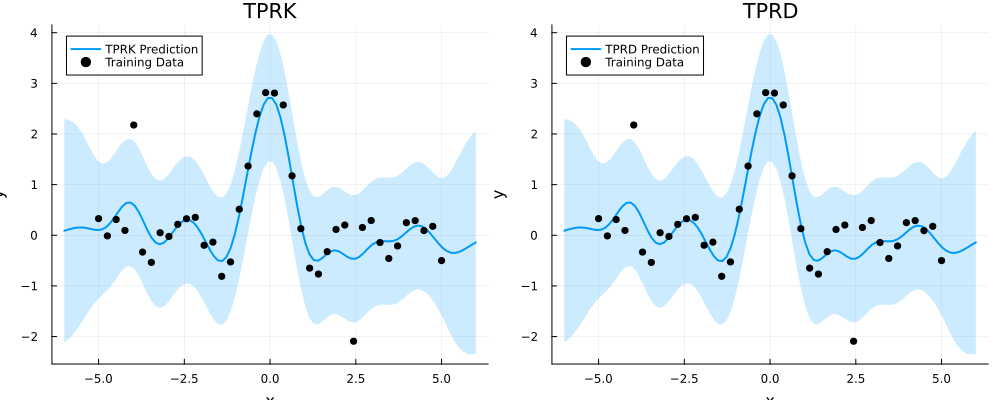

In [1]:
# ############################################################################
#
#   Julia Implementation of TPRK and TPRD
#   Based on:
#     - Shah et al., 2014 - Student-t Processes as Alternatives to Gaussian Processes
#     - Tang et al., 2016 - Student-t process regression with dependent student-t noise
#
# ############################################################################

using Optim
using LinearAlgebra
using SpecialFunctions
using Distributions
using Plots
using Distances

# --- カーネル関数 ---
# Tang et al. (2016) にならい、β-propertyを持たない二乗指数カーネルを使用
struct SquaredExponentialKernel end

# ハイパーパラメータ params_θ は [log_l, log_σ_n]
function kernel_matrix(::SquaredExponentialKernel, X::AbstractMatrix, params_θ::Vector{Float64})
    log_l, log_σ_n = params_θ
    l = exp(log_l)
    σ_n = exp(log_σ_n)
    sq_dist = pairwise(SqEuclidean(), X, dims=2)
    K_se = exp.(-0.5 * sq_dist / l^2)
    K = K_se + Diagonal(fill(σ_n^2 + 1e-6, size(X, 2))) # 安定性のためのジッター
    return K
end

function kernel_matrix_grads(::SquaredExponentialKernel, X::AbstractMatrix, K::AbstractMatrix, params_θ::Vector{Float64})
    log_l, log_σ_n = params_θ
    l = exp(log_l)
    σ_n = exp(log_σ_n)
    n = size(X, 2)
    K_se = K - Diagonal(fill(σ_n^2 + 1e-6, n))
    sq_dist = pairwise(SqEuclidean(), X, dims=2)
    ∂K_∂log_l = K_se .* sq_dist / l^2
    ∂K_∂log_σ_n = Diagonal(fill(2 * σ_n^2, n))
    return [∂K_∂log_l, ∂K_∂log_σ_n]
end


# --- Student-t Process 構造体 ---

mutable struct StudentTProcess
    X::Matrix{Float64}
    y::Vector{Float64}
    kernel::SquaredExponentialKernel
    model_type::Symbol  # :TPRK または :TPRD
    params_θ::Vector{Float64} # [log_l, log_σ_n]
    log_ν_minus_2::Float64    # ν > 2 を保証するために log(ν-2) を最適化

    function StudentTProcess(X, y, model_type; kernel=SquaredExponentialKernel(), init_params_θ=[0.0, 0.0], init_ν=5.0)
        @assert model_type in [:TPRK, :TPRD] "model_typeは :TPRK または :TPRD である必要があります。"
        @assert init_ν > 2 "νは2より大きくなければなりません。"
        new(X, y, kernel, model_type, init_params_θ, log(init_ν - 2))
    end
end

function get_ν(stp::StudentTProcess)
    return exp(stp.log_ν_minus_2) + 2
end

# --- 主要な関数 ---

function log_marginal_likelihood(stp::StudentTProcess)
    X, y, model_type = stp.X, stp.y, stp.model_type
    n = length(y)
    ν = get_ν(stp)
    K = kernel_matrix(stp.kernel, X, stp.params_θ)
    C = cholesky(K)
    α = C \ y
    β = dot(y, α)
    log_det_K = logdet(C)

    if model_type == :TPRK
        # Shah et al. (2014) もしくは Tang et al. (2016) の 式(23) に基づく実装
        # データ項のスケーラーは 1/(ν-2)
        lml = -n/2 * log((ν - 2) * π) # 
        lml -= 0.5 * log_det_K # 
        lml += loggamma((ν + n) / 2) - loggamma(ν / 2) # 
        lml -= (ν + n) / 2 * log(1 + β / (ν - 2)) # 
    else # :TPRD
        # Tang et al. (2016) の 式(20) に基づく実装
        # データ項のスケーラーは 1/ν
        lml = -n/2 * log(ν * π) # 
        lml -= 0.5 * log_det_K # 
        lml += loggamma((ν + n) / 2) - loggamma(ν / 2) # 
        lml -= (ν + n) / 2 * log(1 + β / ν) # 
    end
    return lml
end

function gradient_log_marginal_likelihood(stp::StudentTProcess)
    X, y, model_type = stp.X, stp.y, stp.model_type
    n = length(y)
    ν = get_ν(stp)
    K = kernel_matrix(stp.kernel, X, stp.params_θ)
    C = cholesky(K)
    K⁻¹ = inv(C)
    α = K⁻¹ * y
    β = dot(y, α)

    # --- カーネルハイパーパラメータθに関する勾配 ---
    ∂K_∂θ_list = kernel_matrix_grads(stp.kernel, X, K, stp.params_θ)
    grad_params_θ = zeros(length(stp.params_θ))
    
    if model_type == :TPRK
        common_term = ((ν + n) / (ν - 2 + β)) * (α * α') - K⁻¹
    else # :TPRD
        common_term = ((ν + n) / (ν + β)) * (α * α') - K⁻¹
    end
    
    for i in 1:length(stp.params_θ)
        grad_params_θ[i] = 0.5 * tr(common_term * ∂K_∂θ_list[i])
    end

    # --- νに関する勾配 ---
    if model_type == :TPRK
        # Shah et al. (2014) の補足資料の式に基づく
        ∂lml_∂ν = -n / (2 * (ν - 2)) +
                  0.5 * (digamma((ν + n) / 2) - digamma(ν / 2)) -
                  0.5 * log(1 + β / (ν - 2)) +
                  ((ν + n) * β) / (2 * (ν - 2)^2 + 2 * β * (ν - 2))
    else # :TPRD
        # TPRKの式をνで適応させたもの
        ∂lml_∂ν = -n / (2 * ν) +
                  0.5 * (digamma((ν + n) / 2) - digamma(ν / 2)) -
                  0.5 * log(1 + β / ν) +
                  ((ν + n) * β) / (2 * ν^2 + 2 * β * ν)
    end
    grad_ν = ∂lml_∂ν * (ν - 2) # 連鎖律の適用

    return [grad_params_θ; grad_ν]
end

function fit!(stp::StudentTProcess; max_iters=100)
    objective = p -> -log_marginal_likelihood(
        StudentTProcess(stp.X, stp.y, stp.model_type; kernel=stp.kernel, init_params_θ=p[1:2], init_ν=exp(p[3])+2)
    )
    function gradient!(g, p)
        g[:] = -gradient_log_marginal_likelihood(
            StudentTProcess(stp.X, stp.y, stp.model_type; kernel=stp.kernel, init_params_θ=p[1:2], init_ν=exp(p[3])+2)
        )
    end
    initial_params = [stp.params_θ; stp.log_ν_minus_2]
    result = optimize(objective, gradient!, initial_params, LBFGS(), Optim.Options(iterations=max_iters, show_trace=true))
    optimized_params = Optim.minimizer(result)
    stp.params_θ = optimized_params[1:2]
    stp.log_ν_minus_2 = optimized_params[3]
end

function predict(stp::StudentTProcess, X_new::AbstractMatrix)
    X, y, model_type = stp.X, stp.y, stp.model_type
    n = length(y)
    ν = get_ν(stp)

    K₁₁ = kernel_matrix(stp.kernel, X, stp.params_θ)
    sq_dist_21 = pairwise(SqEuclidean(), X_new, X, dims=2)
    K₂₁ = exp.(-0.5 * sq_dist_21 / exp(stp.params_θ[1])^2)
    K₂₂ = kernel_matrix(stp.kernel, X_new, stp.params_θ)
    
    K₁₁⁻¹y = K₁₁ \ y
    μ_pred = K₂₁ * K₁₁⁻¹y #  (予測平均は両モデルで共通)

    β₁ = dot(y, K₁₁⁻¹y)
    K̃₂₂ = K₂₂ - K₂₁ * (K₁₁ \ K₂₁')
    
    if model_type == :TPRK
        # Shah et al. (2014), Lemma 3 に基づく 
        scaling_factor = (ν + β₁ - 2) / (ν + n - 2)
    else # :TPRD
        # Tang et al. (2016), Eq. 21 に基づく 
        scaling_factor = (ν + β₁) / (ν + n)
    end
    
    Σ_pred = scaling_factor * K̃₂₂
    σ_pred = sqrt.(abs.(diag(Σ_pred)))

    return μ_pred, σ_pred
end

# --- メイン関数（実行例） ---
function main()
    println("--- TPRK vs TPRD 比較実行例 ---")

    n_train = 40
    X_train = reshape(collect(range(-5, 5, length=n_train)), 1, n_train)
    y_train = sinc.(X_train[1,:]) .* 3.0 + rand(Normal(0, 0.2), n_train)
    y_train[5] += 2.0; y_train[30] -= 2.5 # 外れ値を追加

    # --- モデルの初期化 ---
    tprk = StudentTProcess(X_train, y_train, :TPRK, init_params_θ=[log(1.0), log(0.1)], init_ν=5.0)
    tprd = StudentTProcess(X_train, y_train, :TPRD, init_params_θ=[log(1.0), log(0.1)], init_ν=5.0)

    # --- モデルの学習 ---
    println("\n--- TPRKの学習開始 ---")
    fit!(tprk, max_iters=200)
    println("\n--- TPRDの学習開始 ---")
    fit!(tprd, max_iters=200)

    # --- 予測 ---
    n_test = 100
    X_test = reshape(collect(range(-6, 6, length=n_test)), 1, n_test)
    μ_tprk, σ_tprk = predict(tprk, X_test)
    μ_tprd, σ_tprd = predict(tprd, X_test)

    # --- 結果のプロット ---
    p = plot(layout=(1, 2), size=(1000, 400), legend=:topleft)

    # TPRKのプロット
    plot!(p[1], title="TPRK", xlabel="x", ylabel="y")
    plot!(p[1], X_test[1,:], μ_tprk, ribbon=1.96 * σ_tprk, fillalpha=0.2, linewidth=2, label="TPRK Prediction")
    scatter!(p[1], X_train[1,:], y_train, label="Training Data", markersize=4, markercolor=:black)

    # TPRDのプロット
    plot!(p[2], title="TPRD", xlabel="x", ylabel="y")
    plot!(p[2], X_test[1,:], μ_tprd, ribbon=1.96 * σ_tprd, fillalpha=0.2, linewidth=2, label="TPRD Prediction")
    scatter!(p[2], X_train[1,:], y_train, label="Training Data", markersize=4, markercolor=:black)

    display(p)
    
    println("\n--- 最適化されたハイパーパラメータ ---")
    println("TPRK - log(l): $(tprk.params_θ[1]), log(σ_n): $(tprk.params_θ[2]), ν: $(get_ν(tprk))")
    println("TPRD - log(l): $(tprd.params_θ[1]), log(σ_n): $(tprd.params_θ[2]), ν: $(get_ν(tprd))")
end

main()